# Imports

In [1]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.8 MB/s 


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.datasets import cifar10

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.7.0


# Dataset Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir /content/dataset/
!mkdir /content/dataset/diabetes

In [ ]:
!unzip '/content/drive/MyDrive/datasets/diabetes/diabetic-retinopathy-resized-arranged.zip' -d '/content/dataset/diabetes/train'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/dataset/diabetes/train/2/23798_right.jpeg  
  inflating: /content/dataset/diabetes/train/2/23817_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23817_right.jpeg  
  inflating: /content/dataset/diabetes/train/2/23821_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23821_right.jpeg  
  inflating: /content/dataset/diabetes/train/2/23852_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23854_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23905_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23905_right.jpeg  
  inflating: /content/dataset/diabetes/train/2/23906_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23923_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23923_right.jpeg  
  inflating: /content/dataset/diabetes/train/2/23946_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23946_right.jpeg  
  inflating: /content/dat

In [ ]:
import os, shutil, sys 

!mkdir /content/dataset/diabetes/test

def move_to_folder(cur_path, new_path):
    for i in range(5):
      os.mkdir(new_path + str(i))
      files = sorted(os.listdir(cur_path + str(i)))[:6]
      for filename in files:
        shutil.move(os.path.join(cur_path + str(i), filename), os.path.join(new_path + str(i), filename))

move_to_folder('/content/dataset/diabetes/train/', '/content/dataset/diabetes/test/')

In [ ]:
os.rename('/content/dataset/diabetes/train/0', '/content/dataset/diabetes/train/no_dr')
os.rename('/content/dataset/diabetes/train/1', '/content/dataset/diabetes/train/mild')
os.rename('/content/dataset/diabetes/train/2', '/content/dataset/diabetes/train/moderate')
os.rename('/content/dataset/diabetes/train/3', '/content/dataset/diabetes/train/severe')
os.rename('/content/dataset/diabetes/train/4', '/content/dataset/diabetes/train/proliferative_dr')

os.rename('/content/dataset/diabetes/test/0', '/content/dataset/diabetes/test/no_dr')
os.rename('/content/dataset/diabetes/test/1', '/content/dataset/diabetes/test/mild')
os.rename('/content/dataset/diabetes/test/2', '/content/dataset/diabetes/test/moderate')
os.rename('/content/dataset/diabetes/test/3', '/content/dataset/diabetes/test/severe')
os.rename('/content/dataset/diabetes/test/4', '/content/dataset/diabetes/test/proliferative_dr')

# Hyperparameters Setup

In [ ]:
IMAGE_SIZE = 224
PATCH_SIZE = 6
BATCH_SIZE = 32
NUM_CLASSES = 5
INPUT_CLASSES = (32, 32, 3)
EPOCHS = 20
LEARNING_RATE = 1e-4

CLASSES = ['no_dr', 'mild', 'moderate', 'severe', 'proliferative_dr']

# Model Setup

In [ ]:
DF_TRAIN = '/content/dataset/diabetes/train'
DF_TEST  = '/content/dataset/diabetes/test'

# images generator
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                           validation_split = 0.2)

# load training and validating images from directory
train_set = data_gen.flow_from_directory(DF_TRAIN,
                                         subset = 'training',
                                         seed = 645,
                                         color_mode = 'rgb',
                                         shuffle = True,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'categorical')

valid_set = data_gen.flow_from_directory(DF_TRAIN,
                                         subset = 'validation',
                                         seed = 234,
                                         color_mode = 'rgb',
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'categorical')

test_set  = data_gen.flow_from_directory(DF_TEST,
                                         seed = 965,
                                         color_mode = 'rgb',
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'categorical')


Found 28079 images belonging to 5 classes.
Found 7017 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


In [ ]:
train_set.class_indices

{'mild': 0, 'moderate': 1, 'no_dr': 2, 'proliferative_dr': 3, 'severe': 4}

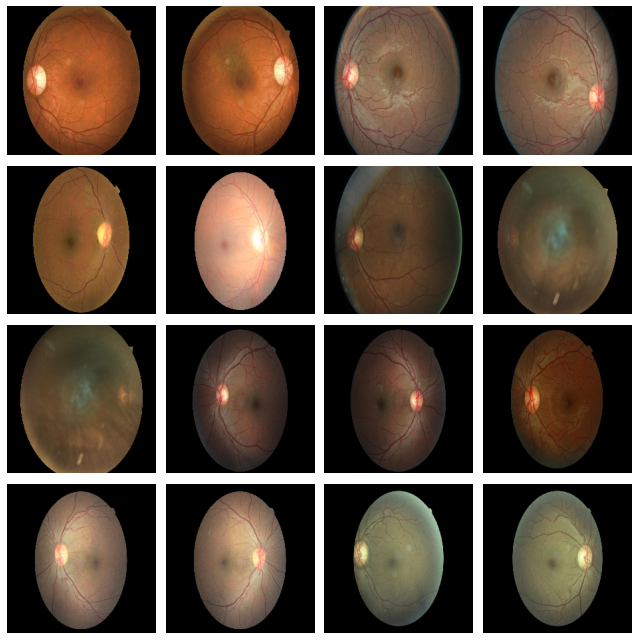

In [ ]:
images = [test_set[0][0][i] for i in range(16)]
# images, labels = next(train_set)[:16]
fig, axes = plt.subplots(4, 4, figsize=(9, 9))
for img, ax in zip(images, axes.flatten()):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Build ViT Model

In [ ]:
!pip install -U vit-keras

**Build ViT B16 model**

In [ ]:
from vit_keras import vit

# build vit model with 16 patch_size
vit_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = NUM_CLASSES)

347512832/347502902 [==============================] - 7s 0us/step


**Visualizing Attention Maps**



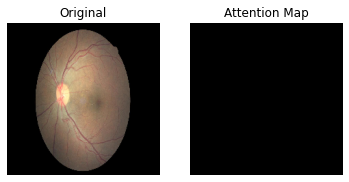

In [ ]:
from vit_keras import visualize

image_to_test = test_set[0][0][0]
attention_map = visualize.attention_map(model = vit_model, image = image_to_test)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

**Model fine-tunning**

In [ ]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(NUM_CLASSES, 'softmax')
    ],
    name = 'vit_model')

model.summary()

Model: "vit_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 5)                 60

# Model training

In [ ]:
STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE)

model.compile(
    optimizer = optimizer, 
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
    metrics=[
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_set,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_set,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

Epoch 1/20
877/877 [==============================] - ETA: 0s - loss: 1.5370 - accuracy: 0.4738 - top-5-accuracy: 1.0000
Epoch 00001: val_accuracy improved from -inf to 0.75342, saving model to ./model.hdf5
877/877 [==============================] - 787s 872ms/step - loss: 1.5370 - accuracy: 0.4738 - top-5-accuracy: 1.0000 - val_loss: 1.0737 - val_accuracy: 0.7534 - val_top-5-accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/20
877/877 [==============================] - ETA: 0s - loss: 1.2560 - accuracy: 0.6821 - top-5-accuracy: 1.0000
Epoch 00002: val_accuracy did not improve from 0.75342
877/877 [==============================] - 759s 865ms/step - loss: 1.2560 - accuracy: 0.6821 - top-5-accuracy: 1.0000 - val_loss: 1.0310 - val_accuracy: 0.7487 - val_top-5-accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/20
877/877 [==============================] - ETA: 0s - loss: 1.0725 - accuracy: 0.7275 - top-5-accuracy: 1.0000
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Ep

# Model Evaluate

In [ ]:
eval_res = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

220/220 [==============================] - 80s 361ms/step - loss: 0.8295 - accuracy: 0.7758 - top-5-accuracy: 1.0000


In [ ]:
# show results
print('Evaluate:')
print('---------------')
print("ACCURACY:",(eval_res['accuracy']))
print("TOP 5 ACCURACY:",(eval_res['top-5-accuracy']))
print("LOSS:",(eval_res['loss']))

Evaluate:
---------------
ACCURACY: 0.7758301496505737
TOP 5 ACCURACY: 1.0
LOSS: 0.8295349478721619


# Predict

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         6
           2       0.22      0.83      0.34         6
           3       0.50      0.33      0.40         6
           4       0.00      0.00      0.00         6

    accuracy                           0.23        30
   macro avg       0.14      0.23      0.15        30
weighted avg       0.14      0.23      0.15        30

Confusion Matrix


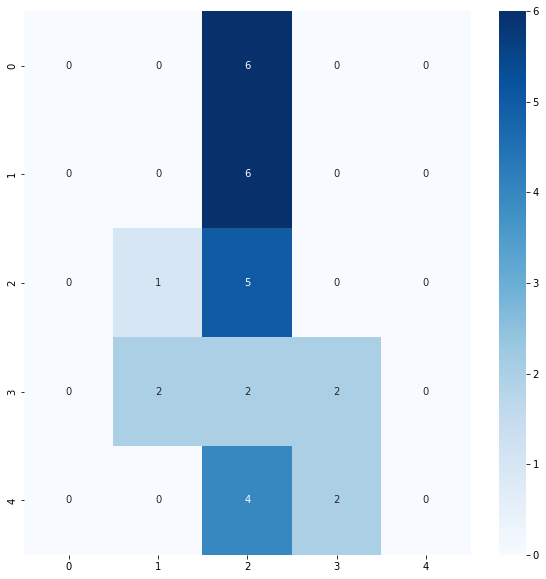

In [ ]:
# predict classes from test dataset
test_set.reset()
Y_pred = model.predict(test_set, steps = test_set.n // test_set.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = len(test_set.class_indices)
class_values = list(test_set.class_indices.values())
class_labels = list(test_set.class_indices.keys())

print('Classification Report')
print(classification_report(test_set.classes, y_pred))

print('Confusion Matrix')
confusionmatrix = confusion_matrix(test_set.classes, y_pred, labels = class_values)
plt.figure(figsize = (10, 10))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)